In [29]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import shutil
import sys
import random
import torch

from matplotlib import colors

PROJ_DIR = os.path.dirname(os.path.abspath('.'))
if PROJ_DIR not in sys.path:
    sys.path.append(PROJ_DIR)

from utils.layout_utils import mean_IU, mean_precision

from kornia.filters import spatial_gradient
from kornia.morphology import dilation


#Increase matplotlib font
plt.rcParams.update({'font.size': 14})

## Set paths

In [2]:
model_output = dict()

model_output["chandrakr_bev"] = '/scratch/shantanu/gibson4/chandrakar_g4/{}/0/{}/pred_bev/{}.png'
model_output["chandrakr_depth"] = '/scratch/shantanu/gibson4/chandrakar_g4/{}/0/{}/pred_depth/{}.png'
model_output["occant_rgb"] = '/scratch/shantanu/results_21022022/occant_rgb/dump/0/{}/{}/bev_pred/{}.png'
model_output["occant_rgbd"] = '/scratch/shantanu/results_21022022/occant_rgbd/dump/0/{}/{}/bev_pred/{}.png'
model_output["occant_ckdepth"] = '/scratch/shantanu/results_21022022/occant_ckdepth/dump/0/{}/{}/bev_pred/{}.png'
model_output["occant_ckbev"] = '/scratch/shantanu/results_21022022/occant_ckbev/dump/0/{}/{}/bev_pred/{}.png'
model_output["basic_transformer"] = '/scratch/shantanu/results_21022022/basic_transformer/{}/{}/{}.png'
model_output["bt_ckdepth_preattn"] = '/scratch/shantanu/results_21022022/ckdepth_resnet/{}/{}/{}.png'

In [3]:
gt_rgb = '/scratch/shantanu/gibson4/new/{}/0/{}/RGB/{}.jpg'
gt_depth = '/scratch/shantanu/gibson4/new/{}/0/{}/DEPTH/{}.png'
gt_semantics = '/scratch/shantanu/gibson4/semantics/{}/0/{}/semantics/{}.png'
gt_bev = '/scratch/shantanu/gibson4/new/{}/0/{}/map/{}.png'
gt_po = '/scratch/shantanu/gibson4/dilated_partialmaps/{}/{}/partial_occ/{}.png'
gt_vo = '/scratch/shantanu/gibson4/visible_occupancy/{}/0/{}/vo/{}.png'

In [4]:
val_split_file = '../splits/gibson4/filtered_front_val_files.txt'
with open(val_split_file, 'r') as f:
    val_fps = f.read().splitlines()
    
val_fps[:5]

['Pablo front 0',
 'Pablo front 1',
 'Pablo front 2',
 'Pablo front 3',
 'Pablo front 4']

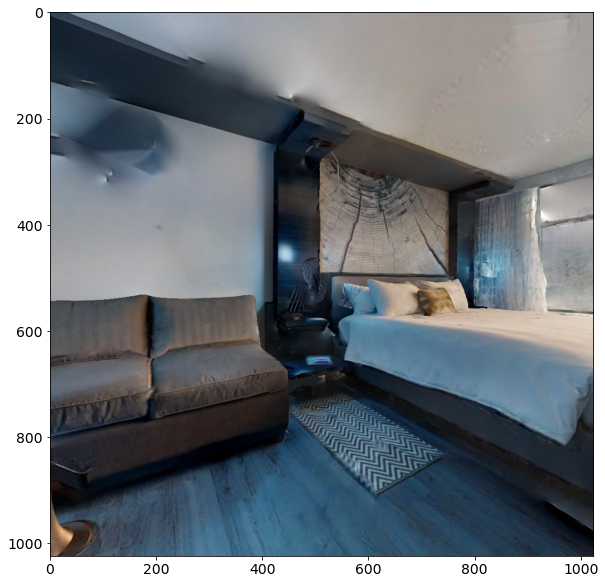

In [5]:
fig = plt.figure(figsize=(20, 10))

rgb_img = cv2.imread(gt_rgb.format(*val_fps[0].split()), -1)
plt.imshow(rgb_img)

# Qualitative

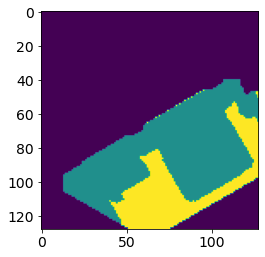

In [8]:
bev_map = cv2.imread(gt_po.format(*val_fps[0].split()), -1)
plt.imshow(bev_map)

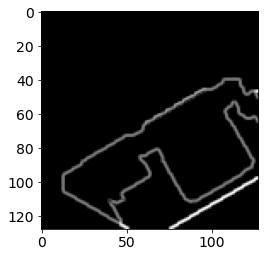

In [19]:
bev_batch = torch.from_numpy(bev_map).unsqueeze(0).unsqueeze(0).float()/127

grad = spatial_gradient(bev_batch)[0].squeeze()
mag = torch.linalg.norm(grad, axis=0)
plt.imshow(mag.numpy(), 'gray')

In [24]:
angle = np.arctan2(grad[1], grad[0])
np.percentile(angle,[0, 100])

array([-2.8198421 ,  3.14159274])

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [3., 2., 1., ..., 0., 0., 0.],
        [2., 4., 4., ..., 0., 0., 0.],
        [3., 1., 1., ..., 0., 0., 0.]]),
 array([-2.819842  , -2.2236986 , -1.6275551 , -1.0314116 , -0.43526816,
         0.16087532,  0.7570188 ,  1.3531623 ,  1.9493058 ,  2.5454493 ,
         3.1415927 ], dtype=float32),
 <a list of 128 BarContainer objects>)

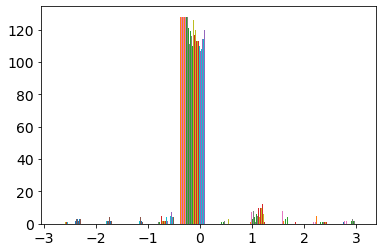

In [27]:
plt.hist(angle)

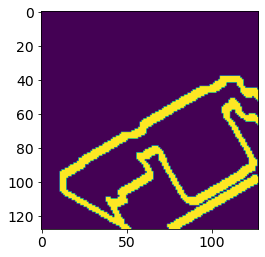

In [38]:
grad_loc = (mag != 0).float().unsqueeze(dim=0).unsqueeze(dim=0)

dilated_gradmap = dilation(grad_loc, kernel=torch.eye(3))[0].squeeze()

plt.imshow(dilated_gradmap)

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([-2.819842  , -2.2236986 , -1.6275551 , -1.0314116 , -0.43526816,
         0.16087532,  0.7570188 ,  1.3531623 ,  1.9493058 ,  2.5454493 ,
         3.1415927 ], dtype=float32),
 <a list of 2179 BarContainer objects>)

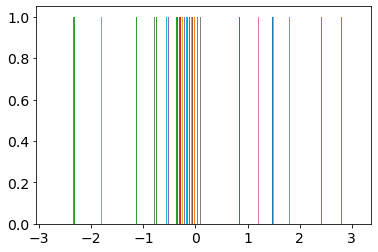

In [53]:
plt.hist(angle[dilated_gradmap.bool()])

In [173]:
bev_size = (128, 128)
model_names = list(model_output.keys())

for fp in val_fps:
    scene, pose, fileidx = fp.split()
    
    # 0 -> unknown, 1 -> occupied, 2 -> free
    tgtbev_fp = gt_po.format(scene, pose, fileidx)
    tgtbev_img = cv2.imread(tgtbev_fp, -1)[64:, 32:96]
    if tgtbev_img is None:
        print("No TGT BEV for {}".format(tgtbev_fp))
    tgtbev_img = cv2.resize(tgtbev_img, dsize=bev_size, interpolation=cv2.INTER_NEAREST)
    tgtbev_img = tgtbev_img // 127 
    
    maskbev_fp = gt_vo.format(scene, pose, fileidx)
    maskbev_img = cv2.imread(maskbev_fp, -1)
    if tgtbev_img is None:
        print("No Mask BEV for {}".format(maskbev_fp))
    maskbev_img = cv2.resize(maskbev_img, dsize=bev_size, interpolation=cv2.INTER_NEAREST)
    maskbev_img = (maskbev_img // 127) == 0
    
    tgtbev_img[maskbev_img] = 4
    
    
    exist_check = [os.path.exists(model_output[model_name].format(scene, pose, fileidx)) for model_name in model_names]
    if not np.all(exist_check):
        print("Missing prediction for {}".format(fp))
        print(np.array(model_names)[~np.array(exist_check)])
        continue
    

    for idx, model_name in enumerate(model_names):
        model_fp = model_output[model_name].format(scene, pose, fileidx)
        model_img = cv2.imread(model_fp, -1).astype(np.uint8)
        model_img = cv2.resize(model_img, dsize=bev_size, interpolation=cv2.INTER_NEAREST)

        if model_name in ['Occupancy Anticipation']:
            model_img = model_img//255 + 1  # Other models follow 0 - occupied, 255 - freespace. Converting to our map
        else:
            model_img = model_img//127  # SCLnet predictions follow 0-unknown, 127-occupied, 254-freespace
            
        model_img[maskbev_img] = 4

        model_IU[model_name].append(mean_IU(model_img, tgtbev_img, 3))
        model_mAP[model_name].append(mean_precision(model_img, tgtbev_img, 3))

In [155]:
for model_name, model_scores in model_mAP.items():
    mean_score = np.mean(np.stack(model_scores), axis=0) * 100
    print(model_name, mean_score)

chandrakr_bev [4.78550459e+01 3.38409475e-02 6.34617284e+01]
chandrakr_depth [39.36230406 20.2380907   2.17084024]
occant_rgb [91.42973775 65.79573051 64.91436849]
occant_rgbd [91.50202876 63.31763827 62.14670759]
occant_ckdepth [85.95390894 64.80512016 69.90988158]
occant_ckbev [89.19288734 67.71842274 69.87084101]
basic_transformer [91.38580711 68.96826019 77.85381517]
bt_ckdepth_preattn [90.22975472 70.76493907 79.03538473]


## Combining unknown and occupied (Cross-view prediction format)

In [87]:
model_IU = dict([(k, []) for k in model_output.keys()])
model_mAP = dict([(k, []) for k in model_output.keys()])

In [88]:
bev_size = (64, 64)
model_names = list(model_output.keys())

for fp in val_fps:
    scene, fileidx = fp.split()
    
    # 0 -> unknown, 1 -> occupied, 2 -> free
    tgtbev_fp = gt_po.format(scene, fileidx)
    tgtbev_img = cv2.imread(tgtbev_fp, -1)
    if tgtbev_img is None:
        print("No TGT BEV for {}".format(fp))
    tgtbev_img = cv2.resize(tgtbev_img, dsize=bev_size, interpolation=cv2.INTER_NEAREST)
    tgtbev_img = tgtbev_img // 254  # Mapping 0,127 -> 0, 254 -> 1
    
    exist_check = [os.path.exists(model_output[model_name].format(scene, fileidx)) for model_name in model_names]
    if not np.all(exist_check):
        print("Missing prediction for {}".format(fp))
        print(np.array(model_names)[~np.array(exist_check)])
        continue
    

    for idx, model_name in enumerate(model_names):
        model_fp = model_output[model_name].format(scene, fileidx)
        model_img = cv2.imread(model_fp, -1).astype(np.uint8)
        model_img = cv2.resize(model_img, dsize=bev_size, interpolation=cv2.INTER_NEAREST)
        
        model_img = model_img//254  # SCLnet predictions follow 0-unknown, 127-occupied, 254-freespace
        

        model_IU[model_name].append(mean_IU(model_img, tgtbev_img, 2))
        model_mAP[model_name].append(mean_precision(model_img, tgtbev_img, 2))

Missing prediction for Darden 85
['crossview']
Missing prediction for Wiconisco 324
['crossview']
Missing prediction for Wiconisco 325
['crossview']
Missing prediction for Corozal 269
['crossview']
Missing prediction for Corozal 282
['crossview']
Missing prediction for Markleeville 24
['crossview']
Missing prediction for Markleeville 25
['crossview']
Missing prediction for Markleeville 26
['crossview']
Missing prediction for Markleeville 27
['crossview']
Missing prediction for Markleeville 28
['crossview']
Missing prediction for Markleeville 58
['crossview']
Missing prediction for Markleeville 59
['crossview']
Missing prediction for Markleeville 60
['crossview']
Missing prediction for Markleeville 61
['crossview']
Missing prediction for Markleeville 62
['crossview']
Missing prediction for Markleeville 63
['crossview']
Missing prediction for Markleeville 64
['crossview']
Missing prediction for Markleeville 65
['crossview']
Missing prediction for Markleeville 66
['crossview']
Missing pre

In [89]:
for model_name, model_scores in model_IU.items():
    mean_score = np.mean(np.stack(model_scores), axis=0) * 100
    print(model_name, mean_score)

occant_rgb [70.24405178 60.41578208]
occant_rgbd [88.68434764 81.75509275]
occant_auxsemantics [71.49043746 61.24511544]
chandrakar [70.56370272 50.30104364]
occant_chandrakarinput [71.85202016 60.39362429]
crossview [76.82392502 66.65717924]


In [83]:
for model_name, model_scores in model_mAP.items():
    mean_score = np.mean(np.stack(model_scores), axis=0) * 100
    print(model_name, mean_score)

occant_rgb [85.22004387 71.47464173]
occant_rgbd [93.44687732 90.13054394]
occant_auxsemantics [85.33091598 72.97136546]
chandrakar [77.10981071 76.02294591]
occant_chandrakarinput [84.12583793 73.86704467]
crossview [87.56329686 77.85022801]
